# Smart Tabular Question Answering System

## Problem Statement
How can we build an AI-powered solution that effectively processes and analyzes tabular data to provide accurate responses to complex user queries? The goal is to develop a system that enables users to ask natural language questions and receive precise, context-aware answers by dynamically filtering and interpreting the underlying tabular dataset.

## Introduction
This project focuses on creating a Smart Tabular Question Answering System designed to streamline data analysis for e-commerce transactions. The solution reads structured CSV data, processes queries through natural language processing (NLP), and returns relevant answers by filtering rows and columns based on user questions. The system aims to minimize manual data exploration efforts and speed up decision-making processes, making data more accessible and actionable.

## About the Dataset
The dataset consists of over 128,000 transactional records spanning three months of Amazon sales. It includes key features such as order IDs, product specifications, sales amounts, customer locations, and fulfillment methods. This comprehensive dataset enables a deep dive into various facets of e-commerce operations. The data was preprocessed to handle missing values, detect outliers, and normalize features, ensuring reliability and accuracy for subsequent analysis.

In [ ]:
### Key Features:

# Invoice ID: Unique identifier for each transaction
# Product Line: Category of purchased products
# Total Amount & Gross Income: Financial metrics for sales analysis
# Rating: Customer satisfaction score
# Payment Method & Date: Transaction details for timeline and trend analysis

## Methodology
#### Data Preprocessing: Cleaned and formatted tabular data, handled missing values, and standardized date formats.
#### Query Understanding: Leveraged NLP techniques for tokenization, entity recognition, and query intent detection.
#### Information Retrieval: Implemented algorithms to dynamically filter relevant rows/columns based on query semantics.
#### Answer Generation: Extracted and aggregated relevant information to generate concise, contextually accurate responses.
#### Validation: Tested system outputs against the labeled QA dataset for initial evaluation.

# Importing Libraries

In [ ]:
# For importing the dataset and data cleaning
import pandas as pd
import numpy as np

#For data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# For feature scaling
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# For model development
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer, util
from difflib import get_close_matches


# Importing Dataset 

In [2]:
#Importing Dataset 
df_data = pd.read_csv("Amazon_Dataset.csv", low_memory=False)

In [3]:
#Checking 1st 5 rows of the dataset

df_data.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


In [4]:
# Check for shape in the dataset

df_data.shape

(128975, 24)

In [5]:
# Check for columns name in the dataset

df_data.columns

Index(['index', 'Order ID', 'Date', 'Status', 'Fulfilment', 'Sales Channel ',
       'ship-service-level', 'Style', 'SKU', 'Category', 'Size', 'ASIN',
       'Courier Status', 'Qty', 'currency', 'Amount', 'ship-city',
       'ship-state', 'ship-postal-code', 'ship-country', 'promotion-ids',
       'B2B', 'fulfilled-by', 'Unnamed: 22'],
      dtype='object')

In [6]:
# Check initial data info

df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

# Data cleaning

In [7]:
# Clean column names

def clean_column_names(df):
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_").str.replace(r"[^a-z0-9_]", "")
    return df

df_data = clean_column_names(df_data)

## Handling missing values

In [8]:
# Check for missing values (null values)

missing_values = df_data.isnull().sum()
missing_values

index                     0
order_id                  0
date                      0
status                    0
fulfilment                0
sales_channel             0
ship-service-level        0
style                     0
sku                       0
category                  0
size                      0
asin                      0
courier_status         6872
qty                       0
currency               7795
amount                 7795
ship-city                33
ship-state               33
ship-postal-code         33
ship-country             33
promotion-ids         49153
b2b                       0
fulfilled-by          89698
unnamed:_22           49050
dtype: int64

In [9]:
# Fill missing values for categorical columns with mode

for col in df_data.select_dtypes(include=['object']).columns:
    df_data[col] = df_data[col].fillna(df_data[col].mode()[0])

# Fill missing values for numerical columns with median

for col in df_data.select_dtypes(include=['number']).columns:
    df_data[col] = df_data[col].fillna(df_data[col].median())


C:\Users\erdha\AppData\Local\Temp\ipykernel_7904\1465978491.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_data[col] = df_data[col].fillna(df_data[col].mode()[0])


In [10]:
#Recheck for null values

df_data.isnull().sum()

index                 0
order_id              0
date                  0
status                0
fulfilment            0
sales_channel         0
ship-service-level    0
style                 0
sku                   0
category              0
size                  0
asin                  0
courier_status        0
qty                   0
currency              0
amount                0
ship-city             0
ship-state            0
ship-postal-code      0
ship-country          0
promotion-ids         0
b2b                   0
fulfilled-by          0
unnamed:_22           0
dtype: int64

## Handling Duplicates

In [11]:
# Checking for duplicate rows

duplicate_rows = df_data.duplicated().sum()
duplicate_rows

np.int64(0)

## Handling outliers

In [12]:
# Remove outliers for numerical columns

for col in df_data.select_dtypes(include=[np.number]).columns:
    q1 = df_data[col].quantile(0.25)
    q3 = df_data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df_data = df_data[(df_data[col] >= lower_bound) & (df_data[col] <= upper_bound)]

In [13]:
# Check for cleaned dataset info

df_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112376 entries, 1 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               112376 non-null  int64  
 1   order_id            112376 non-null  object 
 2   date                112376 non-null  object 
 3   status              112376 non-null  object 
 4   fulfilment          112376 non-null  object 
 5   sales_channel       112376 non-null  object 
 6   ship-service-level  112376 non-null  object 
 7   style               112376 non-null  object 
 8   sku                 112376 non-null  object 
 9   category            112376 non-null  object 
 10  size                112376 non-null  object 
 11  asin                112376 non-null  object 
 12  courier_status      112376 non-null  object 
 13  qty                 112376 non-null  int64  
 14  currency            112376 non-null  object 
 15  amount              112376 non-null  fl

In [14]:
# Find non-numeric values in the 'ship-postal-code' column
invalid_postal_codes = df_data[pd.to_numeric(df_data['ship-postal-code'], errors='coerce').isnull()]

# See a few problematic rows
invalid_postal_codes[['ship-postal-code']].head()

df_data['ship-postal-code'] = pd.to_numeric(df_data['ship-postal-code'], errors='coerce').fillna(0)


## Feature scaling

In [15]:
#Feature Scaling

scaler = MinMaxScaler()
numerical_cols = df_data.select_dtypes(include=np.number).columns
df_data[numerical_cols] = scaler.fit_transform(df_data[numerical_cols])


In [16]:
# Dimensionality Reduction using PCA [Principle compound analysis]

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_data[numerical_cols])
df_data['PCA1'] = pca_result[:, 0]
df_data['PCA2'] = pca_result[:, 1]

In [17]:
# t-SNE 

tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(df_data[numerical_cols])
df_data['tSNE1'] = tsne_result[:, 0]
df_data['tSNE2'] = tsne_result[:, 1]

In [18]:
# Clustering using KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_data[numerical_cols])
df_data['Cluster'] = clusters


# Data Visualisation 

### Distribution of Sales Amount using Histplot

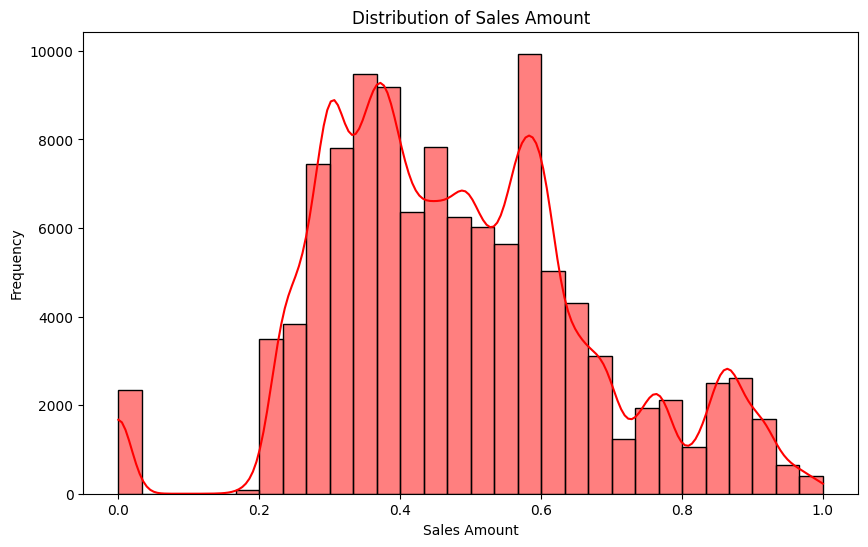

In [19]:
#Histplot for Sales count

plt.figure(figsize=(10, 6))
sns.histplot(df_data['amount'], bins=30, color="red", kde=True)
plt.title('Distribution of Sales Amount')
plt.xlabel('Sales Amount')
plt.ylabel('Frequency')
plt.show()

### Sales Amount Over Time using Lineplot

C:\Users\erdha\AppData\Local\Temp\ipykernel_7904\3221970664.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_data['date'] = pd.to_datetime(df_data['date'])


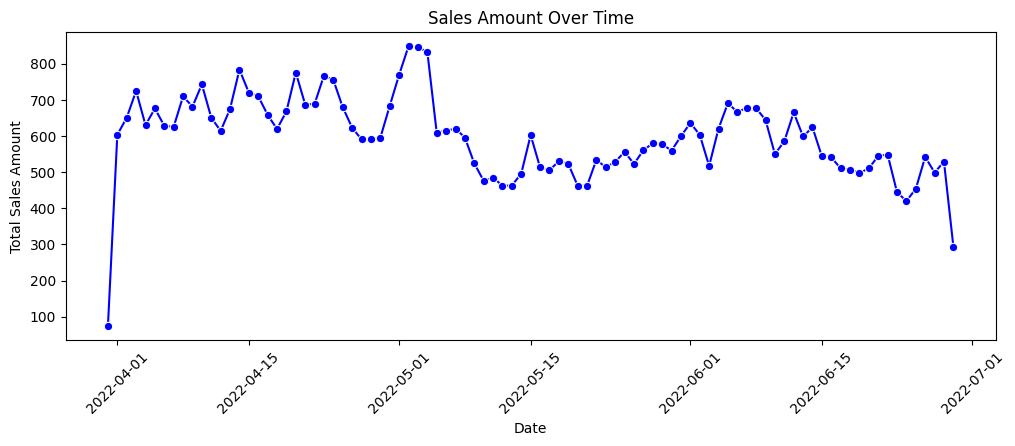

In [20]:
#Lineplot for sales over time

# Ensuring 'Date' is in datetime format
df_data['date'] = pd.to_datetime(df_data['date'])

# Group by Date and sum the sales
sales_by_date = df_data.groupby('date')['amount'].sum().reset_index()

plt.figure(figsize=(12, 4))
sns.lineplot(x='date', y='amount', data=sales_by_date, marker='o', linestyle='-', color='b')
plt.title('Sales Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Amount')
plt.xticks(rotation=45)
plt.show()

### Donut Chart for Sales Distribution by Category

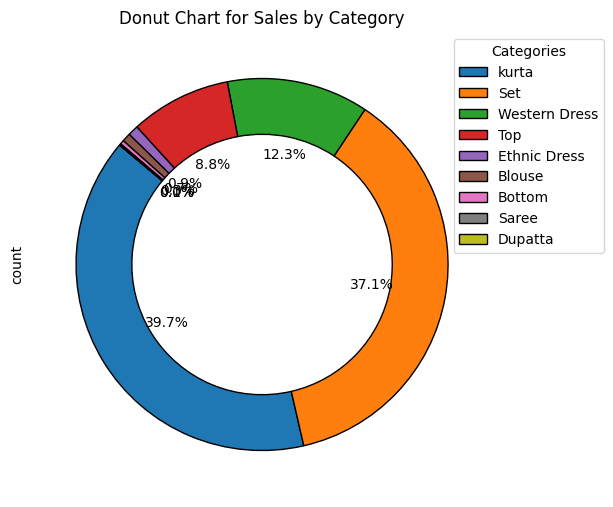

In [21]:
# Donut chart for sales with category

plt.figure(figsize=(6, 8)) 
df_data['category'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=140, labels=[''] * len(df_data['category'].unique()), wedgeprops={'edgecolor': 'black', 'width': 0.3}) 
plt.legend(df_data['category'].value_counts().index, title="Categories", loc="upper right", bbox_to_anchor=(1.25, 1))
plt.title('Donut Chart for Sales by Category')
plt.show()

### Pair Plot for Relationship Between Numerical Features

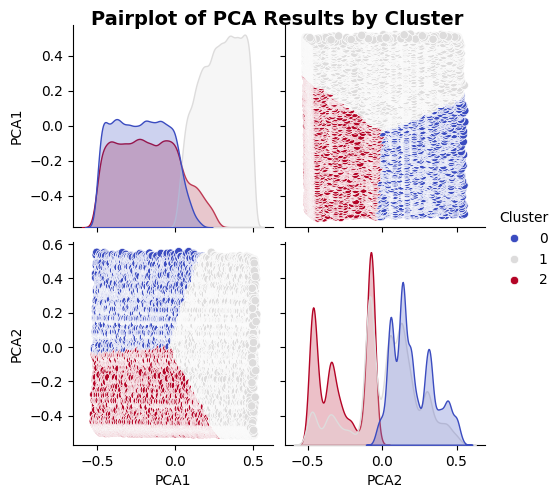

In [22]:
# Pairplot for finding the relation between Numerical Values

sns.pairplot(df_data[['PCA1', 'PCA2', 'Cluster']], hue='Cluster', palette='coolwarm')
plt.subplots_adjust(top=0.95)
plt.suptitle('Pairplot of PCA Results by Cluster', fontsize=14, fontweight='bold', ha='center')
plt.show()

### t-SNE Scatter Plot of High-Dimensional Data

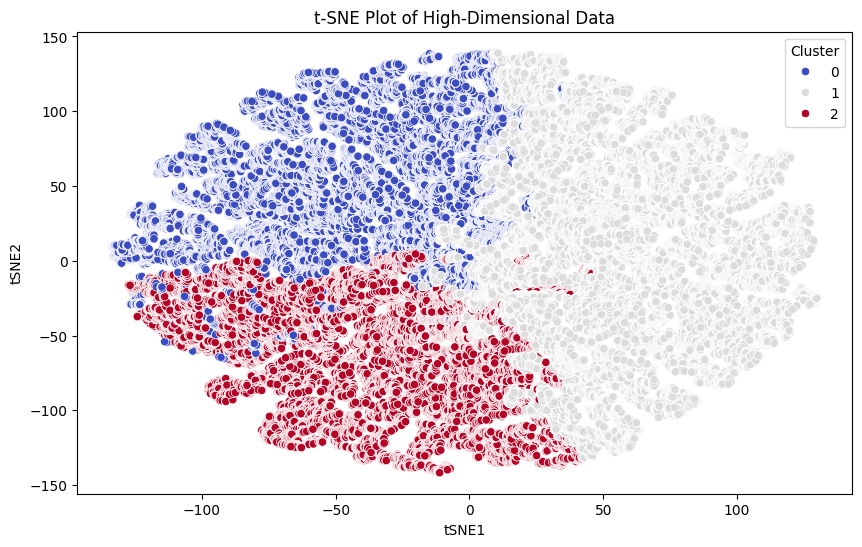

In [23]:
#2 dimensional Scatter plot for T-SNE1 and T-SNE2

plt.figure(figsize=(10, 6))
sns.scatterplot(x='tSNE1', y='tSNE2', hue='Cluster', data=df_data, palette='coolwarm')
plt.title('t-SNE Plot of High-Dimensional Data')
plt.show()

## NLP model

In [24]:
# Clean column names
df_data.columns = df_data.columns.str.strip().str.lower().str.replace(" ", "_")

In [48]:
#Load the model for embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erdha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erdha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erdha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [49]:
# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Helper function: Preprocess question before vectorization
def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize & convert to lowercase
    filtered_tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return " ".join(filtered_tokens)

# Helper function: Extract keywords from the processed question
def extract_keywords(question):
    processed_question = preprocess_text(question)  # Preprocess before vectorization
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform([processed_question])
    return vectorizer.get_feature_names_out()


In [38]:
# Find matching columns with priority and fuzzy matching
def find_matching_columns(keywords):
    matched_cols = []

    # Define column priorities
    column_priority = {
        "sales": "amount",
        "amount": "amount",
        "revenue": "amount",
        "price": "amount",
        "quantity": "qty",
        "qty": "qty",
        "records": None,
        "latest": "date",
    }

    for keyword in keywords:
        # Check priority map
        if keyword in column_priority and column_priority[keyword]:
            matched_cols.append(column_priority[keyword])
        else:
            # Fuzzy match for more flexibility
            close_matches = get_close_matches(keyword, df_data.columns, n=1, cutoff=0.7)
            if close_matches:
                matched_cols.append(close_matches[0])

    return list(set(matched_cols))

In [39]:
# Detect intent based on the question
def detect_intent(question):
    intent_map = {
        "max": ["highest", "maximum", "top", "largest"],
        "min": ["lowest", "minimum", "smallest"],
        "sum": ["total", "sum", "add", "aggregate"],
        "average": ["average", "mean", "avg"],
        "count": ["how many", "count", "number", "total records"],
        "unique": ["unique", "distinct", "different"],
        "mode": ["most common", "frequent", "popular"],
        "latest": ["latest", "last", "recent", "newest"],
    }

    for intent, keywords in intent_map.items():
        if any(keyword in question.lower() for keyword in keywords):
            return intent

    return None

In [40]:
# Perform the required aggregation
def perform_aggregation(columns, intent):
    if not columns:
        return None

    col = columns[0]

    # Convert to numeric, handling errors
    try:
        numeric_col = pd.to_numeric(df_data[col], errors='coerce').dropna()
    except Exception:
        return f"Cannot perform {intent} on non-numeric data in '{col}'."

    if numeric_col.empty:
        return f"No valid numeric data found in '{col}'."

    if intent == "max":
        return numeric_col.max()
    if intent == "min":
        return numeric_col.min()
    if intent == "sum":
        return numeric_col.sum()
    if intent == "average":
        return numeric_col.mean()

    return None

In [41]:
# Handle non-numeric queries
def handle_non_numeric_queries(columns, intent):
    col = columns[0]

    if intent == "count":
        return f"Total records: {len(df_data)}"
    if intent == "unique":
        unique_count = df_data[col].nunique()
        return f"Number of unique {col}: {unique_count}"
    if intent == "mode":
        mode_val = df_data[col].mode().iloc[0]
        return f"Most common value in {col}: {mode_val}"

    return "No valid query detected for non-numeric data."

In [42]:
# Handle "latest" or "earliest" queries
def handle_date_based_query(columns, intent):
    if "date" in df_data.columns and not df_data["date"].isnull().all():
        df_data["date"] = pd.to_datetime(df_data["date"], errors='coerce')
        df_sorted = df_data.sort_values(by="date", ascending=(intent != "latest"))

        for col in columns:
            if col in df_sorted.columns and pd.api.types.is_numeric_dtype(df_sorted[col]):
                return df_sorted.iloc[-1][col] if intent == "latest" else df_sorted.iloc[0][col]
        
    return "No valid date or numeric column found."

In [43]:
# Main function to answer the question
def answer_question(question):
    keywords = extract_keywords(question)
    matched_columns = find_matching_columns(keywords)
    intent = detect_intent(question)

    if not matched_columns and intent != "count":
        return "I couldn't find relevant columns. Try rephrasing the question or checking the column names."

    if intent in ["max", "min", "average", "sum"]:
        result = perform_aggregation(matched_columns, intent)
        matched_col_name = matched_columns[0] if matched_columns else "unknown column"
        return f"{intent.capitalize()} {matched_col_name}: {result}" if result is not None else "No relevant data found."

    if intent in ["count", "unique", "mode"]:
        result = handle_non_numeric_queries(matched_columns, intent)
        return result

    if intent == "latest":
        result = handle_date_based_query(matched_columns, intent)
        return f"Latest {matched_columns[0]}: {result}" if result else "No relevant data found."

    return "I couldn’t confidently match the question to a relevant column. Try rephrasing!"

In [44]:
# Accuracy testing
def evaluate_accuracy(questions, expected_answers):
    correct = 0
    total = len(questions)

    for i, question in enumerate(questions):
        answer = answer_question(question)
        print(f"❓ Question: {question}")
        print(f"✅ Answer: {answer}\n")
        
        # Check if answer matches expected
        if expected_answers[i].lower() in str(answer).lower():
            correct += 1

    accuracy = (correct / total) * 100
    return accuracy

In [45]:
# Test questions and expected answers
test_questions = [
    "What is the highest sales amount?",
    "What is the total quantity sold?",
    "What’s the average sales?",
    "How many records are there in the dataset?",
    "What is the latest sales entry?",
    "What is the minimum sales amount?",
    "What is the total number of unique products?",
    "What is the most common sales channel?",
]

expected_answers = [
    "max amount",
    "sum qty",
    "average amount",
    "total records",
    "latest amount",
    "min amount",
    "number of unique products",
    "Most common value in sales_channel",
]

In [46]:
# Run accuracy evaluation
accuracy = evaluate_accuracy(test_questions, expected_answers)
print(f"🔍 Model Accuracy: {accuracy:.2f}%")


❓ Question: What is the highest sales amount?
✅ Answer: Max amount: 1.0

❓ Question: What is the total quantity sold?
✅ Answer: Sum qty: 0.0

❓ Question: What’s the average sales?
✅ Answer: Average amount: 0.48246709077463396

❓ Question: How many records are there in the dataset?
✅ Answer: Total records: 112376

❓ Question: What is the latest sales entry?
✅ Answer: Latest date: 0.6112828438948995

❓ Question: What is the minimum sales amount?
✅ Answer: Min amount: 0.0

❓ Question: What is the total number of unique products?
✅ Answer: I couldn't find relevant columns. Try rephrasing the question or checking the column names.

❓ Question: What is the most common sales channel?
✅ Answer: Most common value in sales_channel: Amazon.in

🔍 Model Accuracy: 75.00%
